In [1]:
from __future__ import print_function, absolute_import

import lasagne
import numpy
import time
import json
import h5py

import theano
import theano.tensor as T

from lifelines.utils import concordance_index

# Use DeepSurv from the repo
import lasagne
from deepsurv import deep_surv, utils

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
from deepsurv import viz


import deepsurv

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from bayes_opt import bayesian_optimization
import optunity

from lasagne.regularization import regularize_layer_params, l1, l2
from lasagne.nonlinearities import rectify,selu

class DeepSurv:
    def __init__(self, n_in,
    learning_rate, hidden_layers_sizes = None,
    lr_decay = 0.0, momentum = 0.9,
    L2_reg = 0.0, L1_reg = 0.0,
    activation = "selu",
    dropout = None,
    batch_norm = False,
    standardize = False,
    ):

        self.X = T.matrix('x')  # patients covariates
        self.E = T.ivector('e') # the observations vector

        # Default Standardization Values: mean = 0, std = 1
        self.offset = numpy.zeros(shape = n_in, dtype=numpy.float32)
        self.scale = numpy.ones(shape = n_in, dtype=numpy.float32)

        # self.offset = theano.shared(numpy.zeros(shape = n_in, dtype=numpy.float32))
        # self.scale = theano.shared(numpy.ones(shape = n_in, dtype=numpy.float32))

        network = lasagne.layers.InputLayer(shape=(None,n_in),
            input_var = self.X)
        
        network = lasagne.layers.ReshapeLayer(network, (-1,1,n_in))

        # if standardize:
        #     network = lasagne.layers.standardize(network,self.offset,
        #                                         self.scale,
        #                                         shared_axes = 0)
        self.standardize = standardize

        if activation == 'rectify':
            activation_fn = rectify
        elif activation == 'selu':
            activation_fn = selu
        else:
            raise IllegalArgumentException("Unknown activation function: %s" % activation)

        # Construct Neural Network
        for n_layer in (hidden_layers_sizes or []):
            if activation_fn == lasagne.nonlinearities.rectify:
                W_init = lasagne.init.GlorotUniform()
            else:
                # TODO: implement other initializations
                W_init = lasagne.init.GlorotUniform()

            network = lasagne.layers.LSTMLayer(
                network, num_units = n_layer,
                nonlinearity = activation_fn
            )

            if batch_norm:
                network = lasagne.layers.batch_norm(network)

            if not dropout is None:
                network = lasagne.layers.DropoutLayer(network, p = dropout)

        # Combine Linear to output Log Hazard Ratio - same as Faraggi
        network = lasagne.layers.DenseLayer(
            network, num_units = 1,
            nonlinearity = lasagne.nonlinearities.linear,
            W = lasagne.init.GlorotUniform()
        )

        self.network = network
        self.params = lasagne.layers.get_all_params(self.network,
                                                    trainable = True)
        self.hidden_layers = lasagne.layers.get_all_layers(self.network)[1:]

        # Relevant Functions
        self.partial_hazard = T.exp(self.risk(deterministic = True)) # e^h(x)

        # Store and set needed Hyper-parameters:
        self.hyperparams = {
            'n_in': n_in,
            'learning_rate': learning_rate,
            'hidden_layers_sizes': hidden_layers_sizes,
            'lr_decay': lr_decay,
            'momentum': momentum,
            'L2_reg': L2_reg,
            'L1_reg': L1_reg,
            'activation': activation,
            'dropout': dropout,
            'batch_norm': batch_norm,
            'standardize': standardize
        }

        self.n_in = n_in
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        self.L2_reg = L2_reg
        self.L1_reg = L1_reg
        self.momentum = momentum
        self.restored_update_params = None

    def _negative_log_likelihood(self, E, deterministic = False):
        risk = self.risk(deterministic)
        hazard_ratio = T.exp(risk)
        log_risk = T.log(T.extra_ops.cumsum(hazard_ratio))
        uncensored_likelihood = risk.T - log_risk
        censored_likelihood = uncensored_likelihood * E
        num_observed_events = T.sum(E)
        neg_likelihood = -T.sum(censored_likelihood) / num_observed_events
        return neg_likelihood

    def _get_loss_updates(self,
    L1_reg = 0.0, L2_reg = 0.001,
    update_fn = lasagne.updates.nesterov_momentum,
    max_norm = None, deterministic = False,
    momentum = 0.9,
    **kwargs):

        loss = (
            self._negative_log_likelihood(self.E, deterministic)
            + regularize_layer_params(self.network,l1) * L1_reg
            + regularize_layer_params(self.network, l2) * L2_reg
        )

        if max_norm:
            grads = T.grad(loss,self.params)
            scaled_grads = lasagne.updates.total_norm_constraint(grads, max_norm)
            updates = update_fn(
                scaled_grads, self.params, **kwargs
            )
        else:
            updates = update_fn(
                loss, self.params, **kwargs
            )

        if momentum:
            updates = lasagne.updates.apply_nesterov_momentum(updates, 
                self.params, self.learning_rate, momentum=momentum)

        # If the model was loaded from file, reload params
        if self.restored_update_params:
            for p, value in zip(updates.keys(), self.restored_update_params):
                p.set_value(value)
            self.restored_update_params = None

        # Store last update function to be later saved
        self.updates = updates

        return loss, updates

    def _get_train_valid_fn(self,
    L1_reg, L2_reg, learning_rate,
    **kwargs):

        loss, updates = self._get_loss_updates(
            L1_reg, L2_reg, deterministic = False,
            learning_rate=learning_rate, **kwargs
        )
        train_fn = theano.function(
            inputs = [self.X, self.E],
            outputs = loss,
            updates = updates,
            name = 'train'
        )

        valid_loss, _ = self._get_loss_updates(
            L1_reg, L2_reg, deterministic = True,
            learning_rate=learning_rate, **kwargs
        )

        valid_fn = theano.function(
            inputs = [self.X, self.E],
            outputs = valid_loss,
            name = 'valid'
        )
        return train_fn, valid_fn

    def get_concordance_index(self, x, t, e, **kwargs):

        compute_hazards = theano.function(
            inputs = [self.X],
            outputs = -self.partial_hazard
        )
        partial_hazards = compute_hazards(x)

        return concordance_index(t,
            partial_hazards,
            e)

    def _standardize_x(self, x):
        return (x - self.offset) / self.scale

    # @TODO: implement for varios instances of datasets
    def prepare_data(self,dataset):
        if isinstance(dataset, dict):
            x, e, t = dataset['x'], dataset['e'], dataset['t']

        if self.standardize:
            x = self._standardize_x(x)

        # Sort Training Data for Accurate Likelihood
        sort_idx = numpy.argsort(t)[::-1]
        x = x[sort_idx]
        e = e[sort_idx]
        t = t[sort_idx]

        return (x, e, t)

    def train(self,
    train_data, valid_data= None,
    n_epochs = 500,
    validation_frequency = 250,
    patience = 2000, improvement_threshold = 0.99999, patience_increase = 2,
    logger = None,
    update_fn = lasagne.updates.nesterov_momentum,
    verbose = True,
    **kwargs):

        if logger is None:
            logger = DeepSurvLogger('DeepSurv')

        # Set Standardization layer offset and scale to training data mean and std
        if self.standardize:
            self.offset = train_data['x'].mean(axis = 0)
            self.scale = train_data['x'].std(axis = 0)

        x_train, e_train, t_train = self.prepare_data(train_data)

        if valid_data:
            x_valid, e_valid, t_valid = self.prepare_data(valid_data)

        # Initialize Metrics
        best_validation_loss = numpy.inf
        best_params = None
        best_params_idx = -1

        # Initialize Training Parameters
        lr = theano.shared(numpy.array(self.learning_rate,
                                    dtype = numpy.float32))
        momentum = numpy.array(0, dtype= numpy.float32)

        train_fn, valid_fn = self._get_train_valid_fn(
            L1_reg=self.L1_reg, L2_reg=self.L2_reg,
            learning_rate=lr,
            momentum = momentum,
            update_fn = update_fn, **kwargs
        )

        start = time.time()
        for epoch in range(n_epochs):
            # Power-Learning Rate Decay
            lr = self.learning_rate / (1 + epoch * self.lr_decay)
            logger.logValue('lr', lr, epoch)

            if self.momentum and epoch >= 10:
                momentum = self.momentum

            loss = train_fn(x_train, e_train)

            logger.logValue('loss', loss, epoch)
            # train_loss.append(loss)

            ci_train = self.get_concordance_index(
                x_train,
                t_train,
                e_train,
            )
            logger.logValue('c-index',ci_train, epoch)
            # train_ci.append(ci_train)

            if valid_data and (epoch % validation_frequency == 0):
                validation_loss = valid_fn(x_valid, e_valid)
                logger.logValue('valid_loss',validation_loss, epoch)

                ci_valid = self.get_concordance_index(
                    x_valid,
                    t_valid,
                    e_valid
                )
                logger.logValue('valid_c-index', ci_valid, epoch)

                if validation_loss < best_validation_loss:
                    # improve patience if loss improves enough
                    if validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, epoch * patience_increase)

                    best_params = [param.copy().eval() for param in self.params]
                    best_params_idx = epoch
                    best_validation_loss = validation_loss

            if verbose and (epoch % validation_frequency == 0):
                logger.print_progress_bar(epoch, n_epochs, loss, ci_train)

            if patience <= epoch:
                break

        if verbose:
            logger.logMessage('Finished Training with %d iterations in %0.2fs' % (
                epoch + 1, time.time() - start
            ))
        logger.shutdown()
        logger.history['best_valid_loss'] = best_validation_loss
        logger.history['best_params'] = best_params
        logger.history['best_params_idx'] = best_params_idx

        return logger.history


    def risk(self,deterministic = False):
        
        return lasagne.layers.get_output(self.network,
                                        deterministic = deterministic)

    def predict_risk(self, x):
        risk_fxn = theano.function(
            inputs = [self.X],
            outputs = self.risk(deterministic= True),
            name = 'predicted risk'
        )
        return risk_fxn(x)
    
    def recommend_treatment(self, x, trt_i, trt_j, trt_idx = -1):
        """
        Computes recommendation function rec_ij(x) for two treatments i and j.
            rec_ij(x) is the log of the hazards ratio of x in treatment i vs.
            treatment j.
        .. math::
            rec_{ij}(x) = log(e^h_i(x) / e^h_j(x)) = h_i(x) - h_j(x)
        Parameters:
            x: (n, d) numpy array of observations
            trt_i: treatment i value
            trt_j: treatment j value
            trt_idx: the index of x representing the treatment group column
        Returns:
            rec_ij: recommendation
        """
        # Copy x to prevent overwritting data
        x_trt = numpy.copy(x)

        # Calculate risk of observations treatment i
        x_trt[:,trt_idx] = trt_i
        h_i = self.predict_risk(x_trt)
        # Risk of observations in treatment j
        x_trt[:,trt_idx] = trt_j;
        h_j = self.predict_risk(x_trt)

        rec_ij = h_i - h_j
        return rec_ij

In [2]:
# Set environment variable
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0, 1" for multiple GPUs
# impoart tensorflow
import tensorflow as tf
print(tf.__version__)
# Allow growing memmory
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

1.14.0


In [2]:
import argparse
from scipy import stats
from collections import defaultdict
import uuid
import copy
import json
import time
import pylab
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
localtime   = time.localtime()
TIMESTRING  = time.strftime("%m%d%Y%M", localtime)

def evaluate_model(model, dataset, bootstrap = False):

    metrics = {}

    # Calculate c_index
    metrics['c_index'] = model.get_concordance_index(**dataset)
    if bootstrap:
        metrics['c_index_bootstrap'] = utils.bootstrap_metric(model.get_concordance_index, dataset)
    

    return metrics

def plot_survival_curves(rec_t, rec_e, antirec_t, antirec_e, experiment_name = '', output_file = None):
    # Set-up plots
    plt.figure(figsize=(12,3))
    ax = plt.subplot(111)

    # Fit survival curves
    kmf = KaplanMeierFitter()
    kmf.fit(rec_t, event_observed=rec_e, label=' '.join([experiment_name, "Recommendation"]))  
    print("rec median : ",kmf.median_)
    kmf.plot(ax=ax,linestyle="-")
    kmf.fit(antirec_t, event_observed=antirec_e, label=' '.join([experiment_name, "Non-recommendation"]))
    print("Non-rec median : ",kmf.median_)
    kmf.plot(ax=ax,linestyle="--")
    
    # Format graph
    plt.ylim(0,1);
    ax.set_xlabel('Timeline (months)',fontsize='large')
    ax.set_ylabel('Percentage of Population Alive',fontsize='large')
    
    # Calculate p-value
    results = logrank_test(rec_t, antirec_t, rec_e, antirec_e, alpha=.95)
    results.print_summary()

    # Location the label at the 1st out of 9 tick marks
    xloc = max(np.max(rec_t),np.max(antirec_t)) / 9
    plt.legend(loc='best',prop={'size':15})
    print('p-value : ',results.p_value)


    if output_file:
        plt.tight_layout()
        pylab.savefig(output_file)
        
        

def save_treatment_rec_visualizations(model, dataset, output_dir, 
    trt_i = 1, trt_j = 0, trt_idx = 0):
    
    trt_values = np.unique(dataset['x'][:,trt_idx]) # 0,1
    print("Recommending treatments:", trt_values)
    rec_trt = model.recommend_treatment(dataset['x'], trt_i, trt_j, trt_idx)
    rec_trt = np.squeeze((rec_trt < 0).astype(np.int32))

    rec_dict = utils.calculate_recs_and_antirecs(rec_trt, true_trt = trt_idx, dataset = dataset)
    rec_dict_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in rec_dict.items() ]))
    rec_dict_df.to_csv('C:/Users/ASUS/Dropbox/석사학위논문/rec_dict.csv', sep = ',')
    
    output_file = output_dir + 'trt_plot.pdf'
    print(output_file)
    plot_survival_curves(experiment_name = '', output_file=output_file, **rec_dict)

## whas hyperparameter tunning

In [27]:
#hyperparameter tunning
datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/whas_train_test.h5')
train_data = datasets['train']

def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def get_objective_function(num_epochs):

    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'selu',
            'standardize': True
        }
        # @TODO add default parameters and only take necessary args from params
        # protect from params including some other key

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']


        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train, y_train, x_test, y_test,
        **kwargs):
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        hyperparams = get_hyperparams(kwargs)

        network = DeepSurv(n_in=x_train.shape[1], **hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs,
            update_fn = lasagne.updates.nesterov_momentum, verbose = False)

        result = network.get_concordance_index(**valid_data)
        return result

    return train_deepsurv



if __name__ == '__main__':

    NUM_EPOCHS = 500
    NUM_FOLDS = 3

    x = train_data['x']
    e = train_data['e']
    
    t = train_data['t']
    y = np.column_stack((e, t))
    
    

    opt_fxn = get_objective_function(NUM_EPOCHS)
    opt_fxn = optunity.cross_validated(x=x, y=y, num_folds=NUM_FOLDS,
        strata=False)(opt_fxn)

    opt_params, _, _ = optunity.maximize(opt_fxn, num_evals=20,
        learning_rate =[0.01,0.1], 
        lr_decay = [0.0001, 0.001], 
        momentum = [0.8, 0.95],
        L2_reg = [2.0, 7.0], 
        dropout = [0.1, 0.7],
        num_layers = [1,3],
        num_nodes = [20,45])

In [4]:
#첫번쨰
opt_params

{'L2_reg': 3.2627952225224077,
 'dropout': 0.18384765625,
 'learning_rate': 0.0007684349218750001,
 'lr_decay': 0.0008126617030571227,
 'momentum': 0.89404296875,
 'num_layers': 1.7864062500000002,
 'num_nodes': 23.744140625}

In [28]:
#두번째
opt_params

{'L2_reg': 3.31475192669958,
 'dropout': 0.46938144168081264,
 'learning_rate': 0.09832319779821613,
 'lr_decay': 0.0006101093590170168,
 'momentum': 0.8338525390625,
 'num_layers': 1.4641958220661755,
 'num_nodes': 26.564967441983242}

In [32]:
hyperparams = {
"learning_rate": 0.09832319779821613, 
 "dropout": 0.46938144168081264, 
 "lr_decay": 0.0006101093590170168, 
 "momentum": 0.8338525390625, 
 "L2_reg": 3.31475192669958, 
 "batch_norm": False, 
 "standardize": True, 
 "n_in": 6, 
 "hidden_layers_sizes": [26],
 "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/whas_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 700,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.8523798744639756}
Test metrics: {'c_index': 0.8403384003505342, 'c_index_bootstrap': {'mean': 0.8436002241992917, 'confidence_interval': (0.8402740348386629, 0.8469264135599205)}}


In [9]:
hyperparams = {
"learning_rate": 0.09832319779821613, 
 "dropout": 0.46938144168081264, 
 "lr_decay": 0.0006101093590170168, 
 "momentum": 0.8338525390625, 
 "L2_reg": 3.31475192669958, 
 "batch_norm": False, 
 "standardize": True, 
 "n_in": 6, 
 "hidden_layers_sizes": [26],
 "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/whas_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 700,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.8534143725420092}
Test metrics: {'c_index': 0.8406080420641073, 'c_index_bootstrap': {'mean': 0.8391891618772475, 'confidence_interval': (0.8360070765817879, 0.8423712471727071)}}


In [25]:
x_trt = numpy.copy(datasets['test']['x'])

true = model.predict_risk(x_trt)
x_trt[:,4] = 1 #좌심 머시기가 있음
h_1 = model.predict_risk(x_trt)
x_trt[:,4] = 0 #좌심 머시기가 없음
h_0 = model.predict_risk(x_trt)

In [47]:
# CHF = 1일때의 위험도
print(h_1)

[[ 0.221963  ]
 [ 0.26267159]
 [ 0.25539342]
 [ 0.26304236]
 [ 0.21747058]
 [ 0.26446534]
 [ 0.25394489]
 [ 0.21868223]
 [ 0.21299887]
 [ 0.24370851]
 [ 0.23684588]
 [ 0.18150199]
 [ 0.2545483 ]
 [ 0.19429984]
 [ 0.26436187]
 [ 0.20953365]
 [ 0.26545092]
 [ 0.26499525]
 [ 0.28418968]
 [ 0.2244536 ]
 [ 0.20010662]
 [ 0.17934031]
 [ 0.22074594]
 [ 0.03947932]
 [ 0.2405055 ]
 [ 0.21927011]
 [ 0.1841517 ]
 [ 0.26446069]
 [ 0.1509082 ]
 [ 0.25801791]
 [ 0.18329206]
 [ 0.26208781]
 [ 0.1841517 ]
 [ 0.17586066]
 [ 0.26499525]
 [ 0.26556166]
 [ 0.05393019]
 [ 0.26532278]
 [ 0.23418948]
 [ 0.1841517 ]
 [ 0.23779762]
 [ 0.25859269]
 [ 0.24814371]
 [ 0.23331194]
 [ 0.26551173]
 [ 0.23587125]
 [ 0.231578  ]
 [ 0.20741532]
 [ 0.26383483]
 [ 0.22887484]
 [ 0.10623037]
 [-0.01041734]
 [ 0.24125174]
 [ 0.17831949]
 [ 0.26186707]
 [ 0.23633364]
 [ 0.24038689]
 [ 0.23273078]
 [ 0.21411468]
 [ 0.2307589 ]
 [ 0.22459326]
 [ 0.22687438]
 [ 0.26186707]
 [ 0.20172334]
 [ 0.24902121]
 [ 0.2621535 ]
 [ 0.25767

In [48]:
# CHF = 0일때의 위험도
print(h_0)

[[ 0.20611449]
 [ 0.25838684]
 [ 0.23056667]
 [ 0.25914378]
 [ 0.20832612]
 [ 0.26230175]
 [ 0.24578235]
 [ 0.19321058]
 [ 0.19789927]
 [ 0.19632049]
 [ 0.23431627]
 [ 0.17354517]
 [ 0.23865291]
 [ 0.19642306]
 [ 0.26205748]
 [ 0.18765745]
 [ 0.26475203]
 [ 0.26359217]
 [ 0.26403348]
 [ 0.21843096]
 [ 0.19215532]
 [ 0.17182632]
 [ 0.2054477 ]
 [ 0.03325892]
 [ 0.21499887]
 [ 0.21159909]
 [ 0.17710097]
 [ 0.26229072]
 [ 0.13994474]
 [ 0.25065264]
 [ 0.17585951]
 [ 0.25724475]
 [ 0.17710097]
 [ 0.16820507]
 [ 0.26359217]
 [ 0.26504827]
 [ 0.02182357]
 [ 0.26458879]
 [ 0.23322721]
 [ 0.17710097]
 [ 0.1978216 ]
 [ 0.23620828]
 [ 0.23854494]
 [ 0.2328919 ]
 [ 0.26491626]
 [ 0.23390204]
 [ 0.20324698]
 [ 0.18941321]
 [ 0.26085021]
 [ 0.2034006 ]
 [ 0.11097397]
 [-0.01288921]
 [ 0.23167735]
 [ 0.172928  ]
 [ 0.2568276 ]
 [ 0.23011221]
 [ 0.21824982]
 [ 0.23267597]
 [ 0.2149011 ]
 [ 0.20544008]
 [ 0.21736147]
 [ 0.20858632]
 [ 0.2568276 ]
 [ 0.20454242]
 [ 0.2440644 ]
 [ 0.25737009]
 [ 0.25051

In [49]:
#CHF=1 - CHF=0
print(np.exp(rec_trt))

[[1.01597476]
 [1.00429395]
 [1.0251375 ]
 [1.00390619]
 [1.0091864 ]
 [1.00216593]
 [1.00819594]
 [1.02579882]
 [1.01521417]
 [1.04852878]
 [1.0025328 ]
 [1.00798856]
 [1.0160224 ]
 [0.99787903]
 [1.00230705]
 [1.02211725]
 [1.00069914]
 [1.00140406]
 [1.02036071]
 [1.00604082]
 [1.00798299]
 [1.00754229]
 [1.01541586]
 [1.00623978]
 [1.02583471]
 [1.00770052]
 [1.00707564]
 [1.00217233]
 [1.01102378]
 [1.00739246]
 [1.00746023]
 [1.00485481]
 [1.00707564]
 [1.00768496]
 [1.00140406]
 [1.00051352]
 [1.0326276 ]
 [1.00073426]
 [1.00096274]
 [1.00707564]
 [1.04078582]
 [1.02263682]
 [1.00964499]
 [1.00042012]
 [1.00059566]
 [1.00197115]
 [1.02873616]
 [1.01816512]
 [1.00298908]
 [1.02580148]
 [0.99526763]
 [1.00247493]
 [1.00962037]
 [1.00540604]
 [1.00505219]
 [1.00624082]
 [1.02238392]
 [1.00005481]
 [0.99921388]
 [1.02564206]
 [1.007258  ]
 [1.01845631]
 [1.00505219]
 [0.99718489]
 [1.00496912]
 [1.00479487]
 [1.0071794 ]
 [1.0144989 ]
 [1.000522  ]
 [1.01924002]
 [1.00636267]
 [1.00

In [10]:
x_trt = numpy.copy(test_dataset['x'])

true = model.predict_risk(x_trt)
x_trt[:,4] = 1 
h_1 = model.predict_risk(x_trt)
x_trt[:,4] = 0
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(test_dataset['x'], 1, 0, 4)

x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  1.4689153427960906
SE :  [0.02458144]
95% CI :  (array([1.42055763]), array([1.51727306]))


# GBSG

In [11]:
hyperparams ={"learning_rate": 0.0004991066534650134, 
              "dropout": 0.0783935546875, 
              "lr_decay": 0.000746533203125, 
              "momentum": 0.8255483398437501, 
              "L2_reg": 1.5917993164062498, 
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 7, 
              "hidden_layers_sizes": [20, 20, 20], 
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6892878557901049}
Test metrics: {'c_index': 0.6891832992665624, 'c_index_bootstrap': {'mean': 0.6881813636498676, 'confidence_interval': (0.6850514650164563, 0.6913112622832789)}}


In [11]:
hyperparams ={"learning_rate": 0.0004991066534650134, 
              "dropout": 0.0783935546875, 
              "lr_decay": 0.000746533203125, 
              "momentum": 0.8255483398437501, 
              "L2_reg": 1.5917993164062498, 
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 7, 
              "hidden_layers_sizes": [20, 20, 20], 
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6907473299044762}
Test metrics: {'c_index': 0.6889353132138992, 'c_index_bootstrap': {'mean': 0.692478007995837, 'confidence_interval': (0.6895169642310882, 0.6954390517605858)}}


Calculating treatment recommendation survival curvs
Recommending treatments: [-0.5299654  1.886927 ]
Printing treatment recommendation metrics
Recommendation metrics: {'rec_median': 40.098564, 'antirec_median': 31.770021}
C:/Users/ASUS/Dropbox/석사학위논문/model_pathtrt_plot.pdf
rec median :  66.29979705810547
Non-rec median :  50.20123291015625
<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95

---
 test_statistic      p  -log2(p)
           8.56 <0.005      8.19
p-value :  0.0034272822647458657


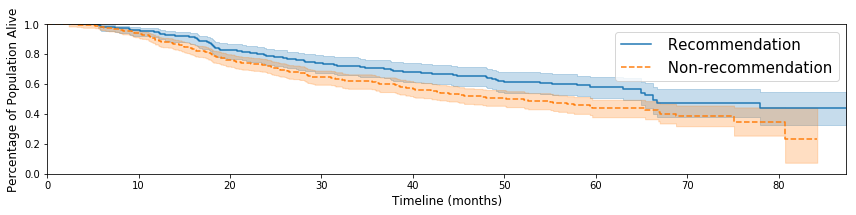

In [96]:
treatment_idx = 0
results_dir = 'C:/Users/ASUS/Dropbox/석사학위논문/model_path'

if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }
    
    if 'test' in datasets and treatment_idx is not None:
        print("Calculating treatment recommendation survival curvs")
        
        # We use the test dataset because these experiments don't have a viz dataset
        save_treatment_rec_visualizations(model, test_dataset, output_dir=results_dir, 
            trt_idx = treatment_idx)

Calculating treatment recommendation survival curvs
Recommending treatments: [-0.5299654  1.886927 ]
Printing treatment recommendation metrics
Recommendation metrics: {'rec_median': 40.098564, 'antirec_median': 31.770021}
C:/Users/ASUS/Dropbox/석사학위논문/model_pathtrt_plot.pdf
rec median :  66.29979705810547
Non-rec median :  50.20123291015625
<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95

---
 test_statistic      p  -log2(p)
           8.56 <0.005      8.19
p-value :  0.0034272822647458657


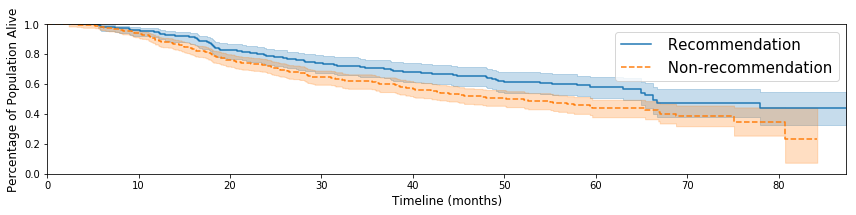

In [22]:
treatment_idx = 0
results_dir = 'C:/Users/ASUS/Dropbox/석사학위논문/model_path'

if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }
    
    if 'test' in datasets and treatment_idx is not None:
        print("Calculating treatment recommendation survival curvs")
        
        # We use the test dataset because these experiments don't have a viz dataset
        save_treatment_rec_visualizations(model, test_dataset, output_dir=results_dir, 
            trt_idx = treatment_idx)

In [ ]:
'''
추천된 trt와 실제 trt가 일치하는 환자들에 대한 생존 곡선과
추천된 trt와 실제 trt가 불일치 하는 환자들에 대한 생존 곡선의 차이가 유의하다.
즉, 모형의 추천대로 trt를 받은 환자는 그렇지 못한 환자들에 비해 더 오래 살았다.
따라서 모형의 trt 예측이 통계적으로 올바른 예측이 된다.
'''

In [51]:
#각 개별 환자의 trt별 효과 차이
rec_trt = model.recommend_treatment(datasets['test']['x'], 1, 0, 0)
print('min : ',np.exp(np.min(rec_trt)))
print('1분위수 : ',np.exp(np.percentile(rec_trt, 25)))
print('중앙값 : ',np.exp(np.median(rec_trt)))
print('3분위수 : ',np.exp(np.percentile(rec_trt, 75)))
print('max : ',np.exp(np.max(rec_trt)))
print('평균 : ',np.exp(np.mean(rec_trt)))
print('표준편차 : ',np.exp(np.std(rec_trt)))

min :  0.2942272530386598
1분위수 :  0.5565689210906419
중앙값 :  0.818760874974022
3분위수 :  0.9503914375992975
max :  1.9000122192036957
평균 :  0.7161766383971048
표준편차 :  1.404735922638979


In [12]:
x_trt = numpy.copy(test_dataset['x'])

true = model.predict_risk(x_trt)
x_trt[:,0] = 1 
h_1 = model.predict_risk(x_trt)
x_trt[:,0] = 0
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(test_dataset['x'], 1, 0, 0)

x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  0.8811286717609781
SE :  [0.00484054]
95% CI :  (array([0.8716246]), array([0.89063274]))


# METABRIC

In [13]:
hyperparams ={"learning_rate": 0.0020065103592061526, 
              "dropout": 0.034404296875000004, 
              "lr_decay": 0.00055220703125, 
              "momentum": 0.8109013671875, 
              "L2_reg": 4.6593974609375,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 9, 
              "hidden_layers_sizes": [42, 42, 42], 
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/metabric_IHC4_clinical_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 100,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.677714616409068}
Test metrics: {'c_index': 0.639087166118387, 'c_index_bootstrap': {'mean': 0.6388228303044652, 'confidence_interval': (0.634113758687543, 0.6435319019213873)}}


In [99]:
hyperparams ={"learning_rate": 0.0020065103592061526, 
              "dropout": 0.34404296875000004, 
              "lr_decay": 0.00055220703125, 
              "momentum": 0.8109013671875, 
              "L2_reg": 4.6593974609375,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 9, 
              "hidden_layers_sizes": [42, 42, 42], 
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/metabric_IHC4_clinical_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 100,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6683277955500707}
Test metrics: {'c_index': 0.6437216808391782, 'c_index_bootstrap': {'mean': 0.6445820998413789, 'confidence_interval': (0.641063713018568, 0.6481004866641898)}}


In [108]:
#각 개별 환자의 trt별 효과 차이
rec_trt = model.recommend_treatment(datasets['test']['x'], 1, 0, 6)
print('min : ',np.exp(np.min(rec_trt)))
print('1분위수 : ',np.exp(np.percentile(rec_trt, 25)))
print('중앙값 : ',np.exp(np.median(rec_trt)))
print('3분위수 : ',np.exp(np.percentile(rec_trt, 75)))
print('max : ',np.exp(np.max(rec_trt)))
print('평균 : ',np.exp(np.mean(rec_trt)))
print('표준편차 : ',np.exp(np.std(rec_trt)))

min :  0.9996152551328391
1분위수 :  0.9998339500011345
중앙값 :  0.9998786317257972
3분위수 :  0.9999280202280008
max :  1.0002416093472866
평균 :  0.9998906542175069
표준편차 :  1.0000854750771593


In [102]:
x_trt = numpy.copy(datasets['test']['x'])

true = model.predict_risk(x_trt)
x_trt[:,6] = 1 #화학요법 받음
h_1 = model.predict_risk(x_trt)
x_trt[:,6] = 0 #화학요법 안받음
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(test_data['x'], 1, 0, 6)

In [103]:
# 화학요법여부 = 1일때의 위험도
print(h_1)

[[1.61635619]
 [1.63079248]
 [1.63448682]
 [1.63307357]
 [1.64050375]
 [1.63943947]
 [1.63904229]
 [1.63818039]
 [1.63882814]
 [1.63724335]
 [1.63414442]
 [1.63538694]
 [1.63384147]
 [1.63066515]
 [1.63304444]
 [1.63997025]
 [1.63848572]
 [1.63628431]
 [1.6383697 ]
 [1.63867343]
 [1.63773017]
 [1.63323953]
 [1.61570368]
 [1.63827027]
 [1.63810594]
 [1.63551443]
 [1.63815199]
 [1.63735835]
 [1.63359621]
 [1.63078497]
 [1.63404612]
 [1.61036352]
 [1.62690913]
 [1.63893304]
 [1.63929034]
 [1.63888899]
 [1.62703874]
 [1.63909705]
 [1.63771467]
 [1.63073867]
 [1.63304125]
 [1.63381122]
 [1.63609382]
 [1.62685149]
 [1.62155198]
 [1.63918594]
 [1.62846554]
 [1.6361712 ]
 [1.63235537]
 [1.61658937]
 [1.6329211 ]
 [1.62387031]
 [1.63869703]
 [1.63730491]
 [1.63320391]
 [1.63804818]
 [1.63359554]
 [1.63454219]
 [1.63314212]
 [1.63996467]
 [1.63150933]
 [1.63278111]
 [1.62271766]
 [1.62455216]
 [1.63544067]
 [1.63491613]
 [1.63799759]
 [1.63904968]
 [1.63519201]
 [1.63720016]
 [1.63014949]
 [1.63

In [104]:
# 화학요법여부 = 0일때의 위험도
print(h_0)

[[1.61639782]
 [1.63078801]
 [1.63458968]
 [1.63320082]
 [1.64061032]
 [1.63954185]
 [1.63922663]
 [1.63831836]
 [1.6390218 ]
 [1.63738323]
 [1.63427375]
 [1.63550085]
 [1.63390376]
 [1.63069726]
 [1.63311347]
 [1.64013079]
 [1.63863353]
 [1.63651303]
 [1.63848794]
 [1.63888115]
 [1.63792942]
 [1.63339097]
 [1.61574252]
 [1.63836956]
 [1.63826998]
 [1.6356425 ]
 [1.6383757 ]
 [1.63755242]
 [1.63373441]
 [1.63073316]
 [1.63423424]
 [1.6104286 ]
 [1.62693384]
 [1.63913471]
 [1.63939697]
 [1.63912767]
 [1.62699805]
 [1.63920949]
 [1.63786636]
 [1.63069069]
 [1.63308373]
 [1.63397955]
 [1.63620336]
 [1.62674126]
 [1.62166519]
 [1.63936022]
 [1.62849359]
 [1.63636169]
 [1.63229778]
 [1.61650222]
 [1.63292727]
 [1.62387252]
 [1.63884992]
 [1.63741577]
 [1.63320711]
 [1.63831074]
 [1.6338075 ]
 [1.6345863 ]
 [1.63324617]
 [1.64007469]
 [1.63160635]
 [1.63272807]
 [1.62274324]
 [1.62445607]
 [1.63565169]
 [1.63497144]
 [1.63813798]
 [1.63921794]
 [1.63522674]
 [1.6373602 ]
 [1.63016102]
 [1.63

In [105]:
#CHF=1 - CHF=0
print(np.exp(rec_trt))

[[1.41217195]
 [1.18666832]
 [1.27857363]
 [1.37257092]
 [1.11697971]
 [1.19803505]
 [1.59103813]
 [1.30679512]
 [1.28415119]
 [1.47349863]
 [1.50344406]
 [1.16074436]
 [1.17571733]
 [1.16884347]
 [1.20010814]
 [1.36462898]
 [1.24496517]
 [1.6009692 ]
 [1.26194617]
 [1.24521196]
 [1.15015364]
 [1.3131271 ]
 [1.28691009]
 [1.26132443]
 [1.77795314]
 [1.5316812 ]
 [1.30734129]
 [1.26482331]
 [1.31772171]
 [1.05512287]
 [1.2504182 ]
 [1.34434334]
 [1.24405584]
 [1.50998403]
 [1.23656061]
 [1.34645006]
 [1.07687727]
 [1.31289628]
 [1.25158998]
 [1.15025103]
 [1.03086123]
 [1.51462387]
 [1.31131915]
 [1.07557972]
 [1.41247087]
 [1.23070448]
 [1.17029674]
 [1.54258637]
 [1.03907487]
 [1.07462057]
 [1.18727901]
 [1.23112548]
 [1.21373158]
 [1.39965499]
 [1.06534903]
 [1.34371804]
 [1.16376857]
 [1.09624248]
 [1.1729761 ]
 [1.26004395]
 [1.15773627]
 [1.03075485]
 [1.32972134]
 [1.10360251]
 [1.59757836]
 [1.14594088]
 [1.5313234 ]
 [1.61299323]
 [1.08911066]
 [1.29986113]
 [1.15212458]
 [1.17

In [109]:
#WHAS 화학요법여부의 ACE
x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  0.9998906542175069
SE :  [4.38459156e-06]
95% CI :  (array([0.99988203]), array([0.99989928]))


In [16]:
x_trt = numpy.copy(test_dataset['x'])

true = model.predict_risk(x_trt)
x_trt[:,6] = 1 
h_1 = model.predict_risk(x_trt)
x_trt[:,6] = 0
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(test_dataset['x'], 1, 0, 6)

x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  1.3697059381297867
SE :  [0.00916941]
95% CI :  (array([1.3516768]), array([1.38773508]))


# SUPPORT

In [24]:
#hyperparameter tunning
datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/support_train_test.h5')
train_data = datasets['train']

def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def get_objective_function(num_epochs):

    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'selu',
            'standardize': True
        }
        # @TODO add default parameters and only take necessary args from params
        # protect from params including some other key

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']


        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train, y_train, x_test, y_test,
        **kwargs):
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        hyperparams = get_hyperparams(kwargs)

        network = DeepSurv(n_in=x_train.shape[1], **hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs,
            update_fn = lasagne.updates.nesterov_momentum, verbose = False)

        result = network.get_concordance_index(**valid_data)
        return result

    return train_deepsurv



if __name__ == '__main__':

    NUM_EPOCHS = 1000
    NUM_FOLDS = 5

    x = train_data['x']
    e = train_data['e']
    
    t = train_data['t']
    y = np.column_stack((e, t))
    
    

    opt_fxn = get_objective_function(NUM_EPOCHS)
    opt_fxn = optunity.cross_validated(x=x, y=y, num_folds=NUM_FOLDS,
        strata=False)(opt_fxn)

    opt_params, _, _ = optunity.maximize(opt_fxn, num_evals=20,
        learning_rate =[0.01,0.05],
        lr_decay = [0.0001, 0.001], 
        momentum = [0.8, 0.95],
        L2_reg = [2.0, 7.0], 
        dropout = [0.3, 0.6],
        num_layers = [1,3],
        num_nodes = [20,45])

In [7]:
#첫번쨰
opt_params

{'L2_reg': 2.771484375,
 'dropout': 0.29277343750000007,
 'learning_rate': 0.013203125,
 'lr_decay': 0.0007626953125,
 'momentum': 0.90107421875,
 'num_layers': 1.72265625,
 'num_nodes': 34.697265625}

In [5]:
#두번째
opt_params

{'L2_reg': 3.11083984375,
 'dropout': 0.6570800781249999,
 'learning_rate': 0.01033203125,
 'lr_decay': 0.000137353515625,
 'momentum': 0.9317626953125,
 'num_layers': 1.7041015625,
 'num_nodes': 41.96044921875}

In [9]:
#세번째
opt_params

{'L2_reg': 6.716796875,
 'dropout': 0.41230468750000004,
 'learning_rate': 0.029140625000000003,
 'lr_decay': 0.0002775390625,
 'momentum': 0.81318359375,
 'num_layers': 1.33203125,
 'num_nodes': 23.955078125}

In [25]:
#네번쨰
opt_params

{'L2_reg': 2.2001953125,
 'dropout': 0.54931640625,
 'learning_rate': 0.049570312500000005,
 'lr_decay': 0.00047880859374999996,
 'momentum': 0.944873046875,
 'num_layers': 1.732421875,
 'num_nodes': 40.7275390625}

In [12]:
hyperparams = {"learning_rate": 0.013203125, 
               "dropout": 0.29277343750000007, 
               "lr_decay": 0.0007626953125, 
               "momentum": 0.90107421875, 
               "L2_reg": 2.771484375, 
               "batch_norm": False, 
               "standardize": True, 
               "n_in": 14, 
               "hidden_layers_sizes": [35,35], 
               "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/support_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 150,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6491997159551604}
Test metrics: {'c_index': 0.6171343531205548, 'c_index_bootstrap': {'mean': 0.6162325018085759, 'confidence_interval': (0.6145522038350946, 0.6179127997820573)}}


In [17]:
hyperparams = {"learning_rate": 0.049570312500000005, 
               "dropout": 0.54931640625, 
               "lr_decay": 0.00047880859374999996, 
               "momentum": 0.944873046875, 
               "L2_reg": 2.2001953125, 
               "batch_norm": False, 
               "standardize": True, 
               "n_in": 14, 
               "hidden_layers_sizes": [41,41], 
               "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/support_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6693106005739599}
Test metrics: {'c_index': 0.6137037437309958, 'c_index_bootstrap': {'mean': 0.6139358744228821, 'confidence_interval': (0.6123454786014307, 0.6155262702443335)}}


In [113]:
#각 개별 환자의 trt별 효과 차이
rec_trt = model.recommend_treatment(datasets['test']['x'], 1, 0, 4)
print('min : ',np.exp(np.min(rec_trt)))
print('1분위수 : ',np.exp(np.percentile(rec_trt, 25)))
print('중앙값 : ',np.exp(np.median(rec_trt)))
print('3분위수 : ',np.exp(np.percentile(rec_trt, 75)))
print('max : ',np.exp(np.max(rec_trt)))
print('평균 : ',np.exp(np.mean(rec_trt)))
print('표준편차 : ',np.exp(np.std(rec_trt)))

min :  0.9161711977758715
1분위수 :  0.999999982144606
중앙값 :  1.000000020480738
3분위수 :  1.000047664847534
max :  1.092235578539729
평균 :  1.0002056175405536
표준편차 :  1.0053136017813795


In [115]:
x_trt = numpy.copy(datasets['test']['x'])

true = model.predict_risk(x_trt)
x_trt[:,4] = 1 #화학요법 받음
h_1 = model.predict_risk(x_trt)
x_trt[:,4] = 0 #화학요법 안받음
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(datasets['test']['x'], 1, 0, 4)

x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

In [118]:
#WHAS 화학요법여부의 ACE
x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  1.0002056175405536
SE :  [0.00012582]
95% CI :  (array([0.99995884]), array([1.00045239]))


In [20]:
x_trt = numpy.copy(test_dataset['x'])

true = model.predict_risk(x_trt)
x_trt[:,6] = 1 
h_1 = model.predict_risk(x_trt)
x_trt[:,6] = 0
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(test_dataset['x'], 1, 0, 6)

x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  1.247117628572232
SE :  [0.00785505]
95% CI :  (array([1.2317115]), array([1.26252376]))


# NWTCO

In [3]:
#nwtco 데이터 불러오기
nwtco = pd.read_csv('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/nwtco.csv')
train_df = nwtco.drop('seqno', axis = 1)
train_df = train_df.rename(columns = {'rel':'Event', 'edrel':'Time'})


#data split
train_df, test_df = train_test_split(train_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.2)

# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')
val_data = dataframe_to_deepsurv_ds(val_df, event_col = 'Event', time_col = 'Time')
test_data = dataframe_to_deepsurv_ds(test_df, event_col = 'Event', time_col = 'Time')

In [24]:
#Hyperparameter tunning
def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def get_objective_function(num_epochs):

    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'selu',
            'standardize': True
        }
        # @TODO add default parameters and only take necessary args from params
        # protect from params including some other key

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']


        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train, y_train, x_test, y_test,
        **kwargs):
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        hyperparams = get_hyperparams(kwargs)

        network = deep_surv.DeepSurv(n_in=x_train.shape[1], **hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs,
            update_fn = lasagne.updates.nesterov_momentum, verbose = False)

        result = network.get_concordance_index(**valid_data)
        return result

    return train_deepsurv



if __name__ == '__main__':

    NUM_EPOCHS = 120
    NUM_FOLDS = 5

    x = train_data['x']
    e = train_data['e']
    
    t = train_data['t']
    y = np.column_stack((e, t))
    
    

    opt_fxn = get_objective_function(NUM_EPOCHS)
    opt_fxn = optunity.cross_validated(x=x, y=y, num_folds=NUM_FOLDS,
        strata=False)(opt_fxn)

    opt_params, _, _ = optunity.maximize(opt_fxn, num_evals=20,
        learning_rate =[0.001,0.01], 
        lr_decay = [0.0001, 0.001], 
        momentum = [0.8, 0.95],
        L2_reg = [2.0, 7.0], 
        dropout = [0.1, 0.4],
        num_layers = [1,3],
        num_nodes = [20,45])

{'learning_rate': [0.001, 0.01], 'lr_decay': [0.0001, 0.001], 'momentum': [0.8, 0.95], 'L2_reg': [2.0, 7.0], 'dropout': [0.1, 0.4], 'num_layers': [1, 3], 'num_nodes': [20, 45], 'num_particles': 10, 'num_generations': 2, 'solver_name': 'particle swarm'}


In [25]:
opt_params

{'L2_reg': 3.3701171875,
 'dropout': 0.1640897839444557,
 'learning_rate': 0.006021831766585077,
 'lr_decay': 0.00046158203124999997,
 'momentum': 0.9012267633106269,
 'num_layers': 2.4120937788122525,
 'num_nodes': 22.008902202887633}

In [4]:
hyperparams ={"learning_rate": 0.0005151337890625001, 
              "dropout": 0.059189453125, 
              "lr_decay": 0.00062470703125, 
              "momentum": 0.812744140625, 
              "L2_reg": 3.7138671875,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 6, 
              "hidden_layers_sizes": [26,26], 
              "activation": "selu"}

if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    
    valid_data = None
    metrics = model.train(train_data, valid_data, n_epochs = 1200,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

C:\Users\ASUS\Anaconda3\lib\site-packages\theano\gpuarray\dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Training metrics: {'c_index': 0.7174880375851357}
Test metrics: {'c_index': 0.7415518863889127, 'c_index_bootstrap': {'mean': 0.7390783960491367, 'confidence_interval': (0.7343040408602651, 0.7438527512380083)}}


In [4]:
hyperparams ={"learning_rate": 0.0005151337890625001, 
              "dropout": 0.059189453125, 
              "lr_decay": 0.00062470703125, 
              "momentum": 0.812744140625, 
              "L2_reg": 3.7138671875,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 6, 
              "hidden_layers_sizes": [26,26], 
              "activation": "selu"}

if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    
    valid_data = None
    metrics = model.train(train_data, valid_data, n_epochs = 1200,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.7177757451025231}
Test metrics: {'c_index': 0.7234871768044675, 'c_index_bootstrap': {'mean': 0.7227165492101829, 'confidence_interval': (0.7171184008972894, 0.7283146975230764)}}


In [121]:
hyperparams ={"learning_rate": 0.0005151337890625001, 
              "dropout": 0.059189453125, 
              "lr_decay": 0.00062470703125, 
              "momentum": 0.812744140625, 
              "L2_reg": 3.7138671875,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 6, 
              "hidden_layers_sizes": [26,26], 
              "activation": "selu"}

if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)
    
    valid_data = None
    metrics = model.train(train_data, valid_data, n_epochs = 1200,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.734662319763123}
Test metrics: {'c_index': 0.6621194234328771, 'c_index_bootstrap': {'mean': 0.662619587478369, 'confidence_interval': (0.6569200485354942, 0.6683191264212438)}}


In [8]:
x_trt = numpy.copy(test_dataset['x'])

true = model.predict_risk(x_trt)
x_trt[:,1] = 1 
h_1 = model.predict_risk(x_trt)
x_trt[:,1] = 0
h_0 = model.predict_risk(x_trt)
rec_trt = model.recommend_treatment(test_dataset['x'], 1, 0, 1)

x = rec_trt
mean = np.exp(np.mean(x))
SE = stats.sem(x)
print('ACE : ',mean)
print('SE : ',  SE)
print('95% CI : ', stats.t.interval(0.95, len(x)-1, loc=mean, scale=SE))

ACE :  1.3208000279490315
SE :  [0.00746401]
95% CI :  (array([1.3061488]), array([1.33545126]))


In [ ]:
hyperparams ={"learning_rate": 0.006021831766585077, 
              "dropout": 0.1640897839444557, 
              "lr_decay": 0.00046158203124999997, 
              "momentum": 0.9012267633106269, 
              "L2_reg": 3.3701171875,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 6, 
              "hidden_layers_sizes": [22,22], 
              "activation": "selu"}

# non-linear

In [3]:
#generate data
def generate_data(treatment_group = False):
    np.random.seed(123)
    sd = deepsurv.datasets.SimulatedData(5, num_features = 15,
        treatment_group = treatment_group)
    train_data = sd.generate_data(2000,method = 'gaussian')
    valid_data = sd.generate_data(600,method = 'gaussian')
    test_data = sd.generate_data(600,method = 'gaussian')

    return train_data, valid_data, test_data

train_data, valid_data, test_data = generate_data()

In [21]:
#hyper-parameter tuning
def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def get_objective_function(num_epochs):

    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'selu',
            'standardize': True
        }
        # @TODO add default parameters and only take necessary args from params
        # protect from params including some other key

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']


        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train, y_train, x_test, y_test,
        **kwargs):
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        hyperparams = get_hyperparams(kwargs)

        network = DeepSurv(n_in=x_train.shape[1], **hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs,
            update_fn = lasagne.updates.nesterov_momentum, verbose = False)

        result = network.get_concordance_index(**valid_data)
        return result

    return train_deepsurv



if __name__ == '__main__':

    NUM_EPOCHS = 1200
    NUM_FOLDS = 5

    x = train_data['x']
    e = train_data['e']
    
    t = train_data['t']
    y = np.column_stack((e, t))
    
    

    opt_fxn = get_objective_function(NUM_EPOCHS)
    opt_fxn = optunity.cross_validated(x=x, y=y, num_folds=NUM_FOLDS,
        strata=False)(opt_fxn)

    opt_params, _, _ = optunity.maximize(opt_fxn, num_evals=10,
        learning_rate =[0.01,0.05],
        lr_decay = [0.0001, 0.001], 
        momentum = [0.8, 0.95],
        L2_reg = [2.0, 7.0], 
        dropout = [0.3, 0.6],
        num_layers = [1,3],
        num_nodes = [20,45])

In [22]:
opt_params

{'L2_reg': 3.943359375,
 'dropout': 0.48808593749999996,
 'learning_rate': 0.031328125,
 'lr_decay': 0.0005798828125,
 'momentum': 0.80029296875,
 'num_layers': 1.81640625,
 'num_nodes': 23.369140625}

In [9]:
hyperparams ={"learning_rate": 0.00511328125, 
              "dropout": 0.70808593749999996, 
              "lr_decay": 0.0005798828125, 
               "momentum": 0.10029296875, 
              "L2_reg": 3.943359375, 
              "batch_norm": False, 
              "standardize": False, 
              "n_in": 15,
              "hidden_layers_sizes": [28,28,28,28,28],
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)

    metrics = model.train(train_data, valid_data, n_epochs = 500,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if hyperparams['standardize']:
        valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, valid_data)
    print("Valid metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6251609088129757}
Valid metrics: {'c_index': 0.6251609088129757}
Test metrics: {'c_index': 0.5883811172217415, 'c_index_bootstrap': {'mean': 0.5866131601633809, 'confidence_interval': (0.5843020547139969, 0.588924265612765)}}


# linear

In [13]:
def generate_data(treatment_group = False):
    np.random.seed(123)
    sd = deepsurv.datasets.SimulatedData(5, num_features = 15,
        treatment_group = treatment_group)
    train_data = sd.generate_data(2000,method = 'linear')
    valid_data = sd.generate_data(600,method = 'linear')
    test_data = sd.generate_data(600,method = 'linear')

    return train_data, valid_data, test_data

train_data, valid_data, test_data = generate_data()

In [14]:
hyperparams ={"learning_rate": 0.00511328125, 
              "dropout": 0.70808593749999996, 
              "lr_decay": 0.0005798828125, 
               "momentum": 0.10029296875, 
              "L2_reg": 3.943359375, 
              "batch_norm": False, 
              "standardize": False, 
              "n_in": 15,
              "hidden_layers_sizes": [28,28,28,28,28],
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = DeepSurv(**hyperparams)

    metrics = model.train(train_data, valid_data, n_epochs = 500,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if hyperparams['standardize']:
        valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, valid_data)
    print("Valid metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.773972482238677}
Valid metrics: {'c_index': 0.773972482238677}
Test metrics: {'c_index': 0.7642525898068893, 'c_index_bootstrap': {'mean': 0.763251035276291, 'confidence_interval': (0.7614059290211695, 0.7650961415314125)}}
